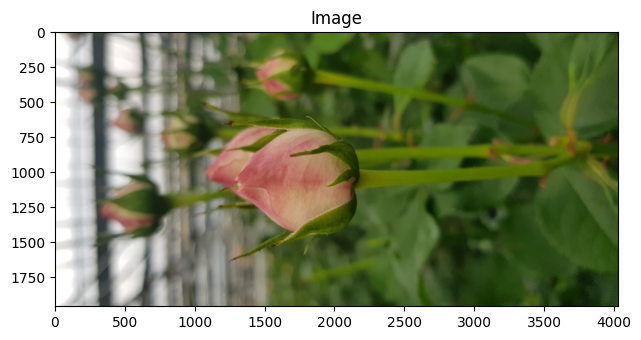

In [1]:
import matplotlib.pyplot as plt
from torchvision.io import read_image


image = read_image("C:/Users/user/Desktop/pj/noa/rose/rose_test/07_20201028_567392.jpg")
# mask = read_image("data/PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
# plt.subplot(122)
# plt.title("Mask")
# plt.imshow(mask.permute(1, 2, 0))

In [16]:
import os
import torch
import json
import matplotlib.pyplot as plt

from torchvision.io import read_image
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import v2 as T
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


import sys
sys.path.append('./detection/')
import utils

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        """
        PennFudan 데이터셋을 초기화합니다.

        Args:
            root (str): 데이터셋의 루트 디렉토리 경로.
            transforms: 이미지 및 타겟 변환을 위한 torchvision.transforms.Compose 객체.
        """
        self.root = root
        self.transforms = transforms
        # 데이터셋 내 모든 이미지 파일을 로드하고 정렬하여 정렬된 이미지 파일 리스트를 생성합니다.
        self.imgs = [f for f in sorted(os.listdir(os.path.join(root, "rose_test"))) if f.endswith(('.jpg', '.png'))]

    def load_data(self, filename):
        """
        지정된 파일 이름에 대한 이미지와 타겟을 로드합니다.

        Args:
            filename (str): 이미지 파일 이름.

        Returns:
            tuple: 이미지와 타겟 딕셔너리.
        """
        # 이미지 파일 경로 설정
        img_path = os.path.join(self.root, "rose_test", filename)
        # 해당 이미지에 대한 JSON 파일 경로 설정
        json_path = os.path.join(self.root, "rose_test", os.path.splitext(filename)[0] + '.json')
        
        # JSON 파일 열기 및 데이터 로드
        with open(json_path, 'r') as f:
            data = json.load(f)
        
        # 이미지 읽어오기
        img = read_image(img_path)
        
        # 어노테이션 데이터 가져오기
        annotations = data['annotations']
        image_id = annotations[0]['image_id']
        height = 1960  # 예시에서는 고정값 사용
        width = float(data['images'][0]['width'])
        
        # 바운딩 박스 정보 가져오기
        bbox = annotations[0]['bbox']
        bbox = (bbox[1], height - (bbox[0] + bbox[2]), bbox[1] + bbox[3], height - bbox[0])
        
        # 객체 영역(area) 가져오기
        area = annotations[0]['area']
        
        # 객체 ID(obj_ids) 가져오기
        obj_ids = [annotation['category_id'] for annotation in annotations]
        obj_ids = torch.unique(torch.tensor(obj_ids))
        num_objs = len(obj_ids)
        
        # iscrowd 및 labels 생성
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        
        # torchvision에서 제공하는 데이터 타입으로 이미지를 변환합니다.
        img = tv_tensors.Image(img)
        
        # 타겟 딕셔너리 생성
        target = {
            "boxes": tv_tensors.BoundingBoxes(bbox, format="XYXY", canvas_size=F.get_size(img)),
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        # 변환이 지정되어 있다면 이미지와 타겟에 변환을 적용합니다.
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __getitem__(self, index):
        """
        데이터셋에서 지정된 인덱스에 해당하는 이미지와 타겟을 반환합니다.

        Args:
            index (int): 데이터셋의 인덱스.

        Returns:
            tuple: 이미지와 타겟 딕셔너리.
        """
        return self.load_data(self.imgs[index])
  
    def __len__(self):
        """
        데이터셋의 총 길이를 반환합니다.

        Returns:
            int: 데이터셋의 총 길이.
        """
        return len(self.imgs)

    def get_item_by_filename(self, filename):
        """
        지정된 파일 이름에 해당하는 이미지와 타겟을 반환합니다.

        Args:
            filename (str): 이미지 파일 이름.

        Returns:
            tuple: 이미지와 타겟 딕셔너리.
        """
        return self.load_data(filename)


In [17]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [18]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# 이미지 분류를 위한 사전 훈련된 모델을 불러와서
# 특성만 반환합니다.
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN``은 백본(backbone)의 출력 채널 수를 알아야 합니다.
# 모바일넷(MobileNet) v2의 경우 출력 채널 수가 1280입니다.
# 따라서 이를 여기에 추가해야 합니다.
backbone.out_channels = 1280

# RPN이 공간 위치마다 5 x 3 개의 앵커를 생성하도록 만듭니다.
# 각 공간 위치마다 5개의 다른 크기와 3개의 다른 종횡비가 있습니다.
# 각 feature map에 대한 크기와 종횡비를 나타내기 위해
# Tuple[Tuple[int]] 형식을 사용합니다.
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# ROI Align을 수행할 특성 맵(feature map)과
# 크기 조정 후 자르기(cropping) 후의 크기를 정의합니다.
# 백본(backbone)이 Tensor를 반환하면 featmap_names가 [0]이어야 합니다.
# 일반적으로 백본은 ``OrderedDict[Tensor]``를 반환하며,
# featmap_names에서 사용할 특성 맵을 선택할 수 있습니다.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# Faster-RCNN 모델 내부에 모든 요소들을 합칩니다.
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)


In [20]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # COCO 데이터셋으로 미리 학습된 인스턴스 분할 모델을 불러옵니다.
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # 분류기의 입력 특징 개수를 가져옵니다.
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # 미리 학습된 분류기를 새로운 분류기로 교체합니다.
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # 마스크 분류기의 입력 특징 개수를 가져옵니다.
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # 새로운 마스크 분류기로 마스크 예측기를 교체합니다.
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model


In [21]:
print(in_features)

1024


In [22]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [23]:
from torch.utils.data import DataLoader
import sys

# 사용자 정의 모듈을 import합니다.
sys.path.append('./detection/')
import utils

# utils 모듈을 출력합니다.
print(utils)

# 사전 학습된 Faster R-CNN 모델을 불러옵니다.
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# PennFudanDataset을 생성하고 데이터 변환을 설정합니다.
dataset = PennFudanDataset('data/rose', get_transform(train=True))

# DataLoader를 설정합니다.
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

# 학습을 위한 코드
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # 손실과 감지 결과를 반환합니다.
print(output)

# 추론을 위한 코드
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # 예측 결과를 반환합니다.
print(predictions[0])


<module 'utils' from 'c:\\Users\\user\\Desktop\\pj\\noa\\./detection\\utils.py'>


FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'data/rose\\rose_test'